# Repeat until success

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime.fake_provider import FakeAlmadenV2 as FakeProvider
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

from qiskit.visualization import plot_distribution

from qiskit_ibm_runtime.utils.validations import is_isa_circuit

In [2]:
controls = QuantumRegister(2, 'controls')
target = QuantumRegister(1, 'target')

mid_measurement = ClassicalRegister(2, 'mid')
final_measurement = ClassicalRegister(1, 'final')

circuit = QuantumCircuit(controls, target, mid_measurement, final_measurement)

### Circuit Explanation

First Hadamard and Toffoli gates are applied to the first 3 qubits. This is to create a superposition of all possible states of the first 3 qubits. i.e:
$$
\frac{1}{\sqrt{8}} \sum_{x=0}^{7} |x\rangle
$$

The S gate applied on 3rd qubit results in a phase shift of $i$ on the state $|1xx\rangle$ where $x$ is either 0 or 1. The state after this operation is:

$$
\frac{1}{\sqrt{8}} \sum_{x=0}^{7} i^{\delta_{x,1}} |x\rangle
$$

Then we reverse the operation on the first 3 qubits. **Note: The first $H^{\otimes n}$ gate creates a superposition of all possible states of the first 3 qubits. The second $H^{\otimes n}$ gate is used for interference.** The state after this operation is:

$$
\frac{1}{\sqrt{8}} \sum_{x=4}^{7} i^{\delta_{x,1}} |x\rangle + \frac{1}{\sqrt{2}} |000\rangle
$$

Target in $|1\rangle$ shows that $R_x(pi)$ is applied on the target qubit(X gate) while $R_z(\frac{\pi}{\theta})$ is applied on the target qubit if target is $|0\rangle$.

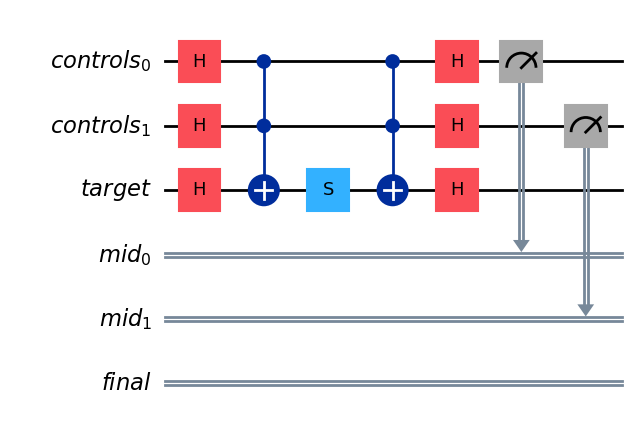

In [3]:
def trial(circuit: QuantumCircuit, controls: QuantumRegister, target: QuantumRegister, mid_measurement: ClassicalRegister, final_measurement: ClassicalRegister):
    circuit.h(controls)
    circuit.h(target)
    circuit.ccx(*controls, target)
    circuit.s(target)
    circuit.ccx(*controls, target)
    circuit.h(controls)
    circuit.h(target)

    circuit.measure(controls, mid_measurement)

    
trial(circuit, controls, target, mid_measurement, final_measurement)
circuit.draw(output="mpl", style='iqp', cregbundle=False)

In [4]:
def reset_controls(circuit: QuantumCircuit, controls: QuantumRegister, measures: ClassicalRegister):
    """Reset the controls if target is 1"""

    with circuit.if_test((measures[0], True)):
        circuit.x(controls[0])
    with circuit.if_test((measures[1], True)):
        circuit.x(controls[1])    

We can tell from the measurement whether the correct gate was applied, without disturbing the coherence of the target qubit. Thus can retry the setup again.

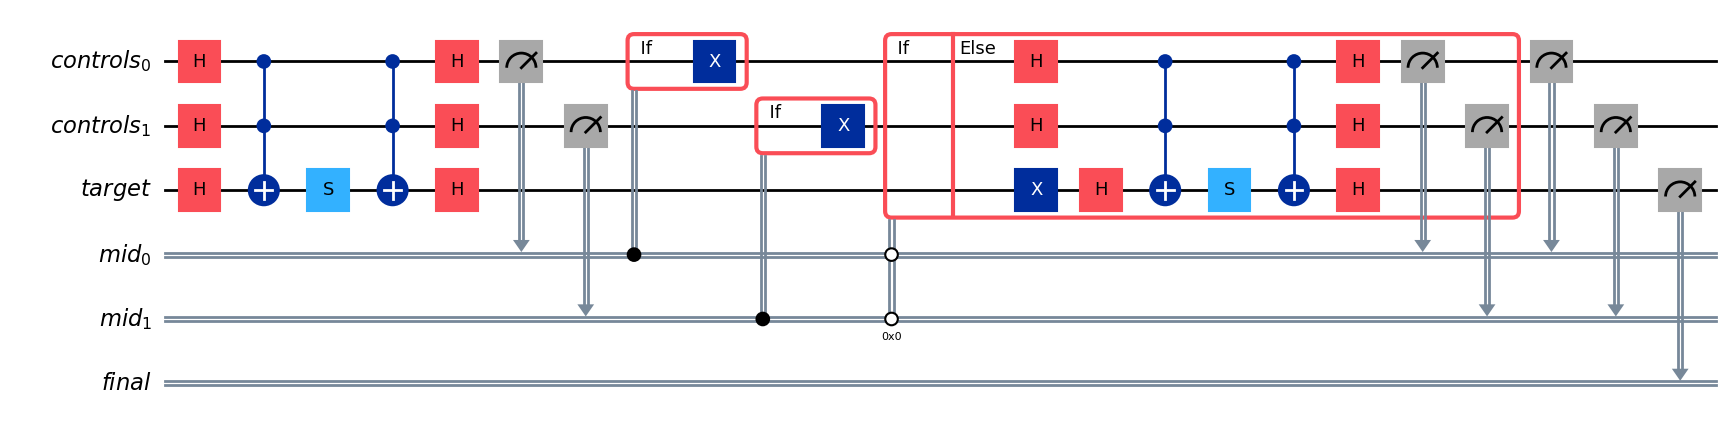

In [5]:
max_trials = 2

for i in range(max_trials - 1):
  reset_controls(circuit, controls, mid_measurement)
  with circuit.if_test((mid_measurement, 0b00)) as _else:
    pass
  with _else:
    # Reset target
    circuit.x(target)
    trial(circuit, controls, target, mid_measurement, final_measurement)

circuit.measure(controls, mid_measurement)
circuit.measure(target, final_measurement)

circuit.draw(output="mpl", style='iqp', cregbundle=False)

In [10]:
# from qiskit_ibm_runtime import QiskitRuntimeService
# # Setup Qiskit Runtime Service

# service = QiskitRuntimeService(
#   channel='ibm_quantum',
# )

# service.backends()

[<IBMBackend('ibm_brisbane')>,
 <IBMBackend('ibm_kyoto')>,
 <IBMBackend('ibm_osaka')>,
 <IBMBackend('ibm_sherbrooke')>]

In [13]:
from qiskit_ibm_runtime.fake_provider import FakeAlgiers as FakeProvider

backend = FakeProvider()
# backend = service.get_backend('ibm_brisbane')
print(f">>> Connected to {backend.name} backend.")

pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
optimized_circuit = pm.run(circuit)

/tmp/ipykernel_269912/257903536.py:4: DeprecationWarning: The get_backend() method is deprecated as of qiskit-ibm-runtime 0.24 and will be removed no sooner than 3 months after the release date. Please use backend() instead.
  backend = service.get_backend('ibm_brisbane')


>>> Connected to ibm_brisbane backend.


In [14]:
is_isa_circuit(optimized_circuit, backend.target)

'The instruction ecr on qubits (1, 2) is not supported by the target system.'

Couldn't be implemented in Qiskit because of the limitation of free accounts.

In [ ]:
sampler = Sampler(backend)
job = sampler.run([optimized_circuit])
job.job_id()